<a href="https://colab.research.google.com/github/Zardian18/DCGAN-vs-WGAN-NFT-generation/blob/master/DCGAN_vs_WGANGP_NFT_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing image generations from DCGAN and WGAN-GP on NFT Dataset

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-08 22:06:41--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-08 22:06:42 (28.5 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d tanmaypatil3151/cryptopunk-nft-10k-dataset

 67% 5.00M/7.49M [00:00<00:00, 44.4MB/s]
100% 7.49M/7.49M [00:00<00:00, 51.0MB/s]


In [8]:
! unzip cryptopunk-nft-10k-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cryptopunk5499.jpg  
  inflating: data/cryptopunk55.jpg   
  inflating: data/cryptopunk550.jpg  
  inflating: data/cryptopunk5500.jpg  
  inflating: data/cryptopunk5501.jpg  
  inflating: data/cryptopunk5502.jpg  
  inflating: data/cryptopunk5503.jpg  
  inflating: data/cryptopunk5504.jpg  
  inflating: data/cryptopunk5505.jpg  
  inflating: data/cryptopunk5506.jpg  
  inflating: data/cryptopunk5507.jpg  
  inflating: data/cryptopunk5508.jpg  
  inflating: data/cryptopunk5509.jpg  
  inflating: data/cryptopunk551.jpg  
  inflating: data/cryptopunk5510.jpg  
  inflating: data/cryptopunk5511.jpg  
  inflating: data/cryptopunk5512.jpg  
  inflating: data/cryptopunk5513.jpg  
  inflating: data/cryptopunk5514.jpg  
  inflating: data/cryptopunk5515.jpg  
  inflating: data/cryptopunk5516.jpg  
  inflating: data/cryptopunk5517.jpg  
  inflating: data/cryptopunk5518.jpg  
  inflating: data/cryptopunk5519.jpg  
  inflating: dat

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers
from helper import sample_batch, display, get_vector_from_label, add_vector_to_images, morph_faces
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [10]:
train_data = utils.image_dataset_from_directory(
    "/content/data",
    labels= None,
    color_mode= "rgb",
    image_size=(32,32),
    batch_size=32,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 9999 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [11]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

In [12]:
train = train_data.map(lambda x: preprocess(x))
train

<_MapDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

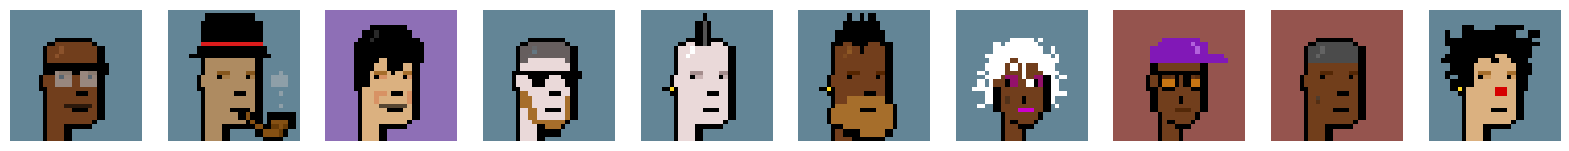

In [13]:
train_sample = sample_batch(train)
display(train_sample)

## DCGAN

### Discriminator

In [29]:
discriminator_input = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Flatten()(x)

discriminator_output = layers.Dense(1, activation='sigmoid')(x)
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_16 (Ba  (None, 8, 8, 128)         512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                           

### Generator

In [31]:
generator_input = layers.Input(shape=(100,))

x = layers.Dense(4 * 4 * 256, use_bias=False)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Reshape((4, 4, 256))(x)

x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False)(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_5 (Dense)             (None, 4096)              409600    
                                                                 
 batch_normalization_23 (Ba  (None, 4096)              16384     
 tchNormalization)                                               
                                                                 
 re_lu_4 (ReLU)              (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_14 (Conv2  (None, 8, 8, 128)         819200    
 DTranspose)                                               

In [35]:
class DCGAN(models.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(DCGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim


  def compile(self, d_optimizer, g_optimizer):
    super(DCGAN, self).compile()
    self.loss_fn = losses.BinaryCrossentropy()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.d_loss_metric = metrics.Mean(name="d_loss")
    self.d_real_acc_metric = metrics.Mean(name="d_real_acc")
    self.d_fake_acc_metric = metrics.Mean(name="d_fake_acc")
    self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
    self.g_loss_metric= metrics.Mean(name="g_loss")
    self.g_acc_metric = metrics.Mean(name="g_acc")


  @property
  def metrics(self):
    return[
        self.d_loss_metric,
        self.d_real_acc_metric,
        self.d_fake_acc_metric,
        self.d_acc_metric,
        self.g_loss_metric,
        self.g_acc_metric,
    ]


  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = self.generator(random_latent_vectors, training = True)
      real_prediction = self.discriminator(real_images, training = True)
      fake_prediction= self.discriminator(generated_images, training = True)
      real_labels = tf.ones_like(real_prediction)
      fake_labels = tf.zeros_like(fake_prediction)

      real_noisy_labels = real_labels - 0.1*tf.random.uniform(tf.shape(real_prediction))
      fake_noisy_labels = fake_labels + 0.1*tf.random.uniform(tf.shape(fake_prediction))

      d_real_loss = self.loss_fn(real_noisy_labels, real_prediction)
      d_fake_loss = self.loss_fn(fake_noisy_labels, fake_prediction)

      d_loss = (d_real_loss + d_fake_loss)/2.0
      g_loss = self.loss_fn(real_labels, fake_prediction)

    gradient_of_discriminator= disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
    gradient_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

    self.d_optimizer.apply_gradients(zip(gradient_of_discriminator, self.discriminator.trainable_variables))
    self.g_optimizer.apply_gradients(zip(gradient_of_generator, self.generator.trainable_variables))

    self.d_loss_metric.update_state(d_loss)
    self.d_real_acc_metric.update_state(real_labels, real_prediction)
    self.d_fake_acc_metric.update_state(fake_labels, fake_prediction)
    self.d_acc_metric.update_state([real_labels, fake_labels], [real_prediction, fake_prediction])
    self.g_loss_metric.update_state(g_loss)
    self.g_acc_metric.update_state(real_labels, fake_prediction)

    return {m.name: m.result() for m in self.metrics}

In [36]:
dcgan3 = DCGAN(
    discriminator= discriminator,
    generator= generator,
    latent_dim= 100
)

In [37]:
dcgan3.compile(
    d_optimizer = optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5, beta_2 = 0.99),
    g_optimizer = optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.99),
)

In [19]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

In [20]:
! mkdir output/

Epoch 1/50
  6/313 [..............................] - ETA: 14s - d_loss: 0.4569 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.8776 - g_loss: 3.1134 - g_acc: 1.0000

313/313 [==============================] - ETA: 0s - d_loss: 0.2688 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9805 - g_loss: 3.6129 - g_acc: 1.0000
Saved to ./output/generated_img_000.png


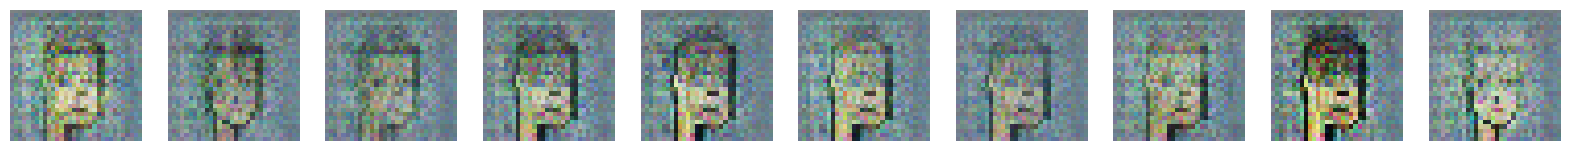

313/313 [==============================] - 22s 41ms/step - d_loss: 0.2688 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9805 - g_loss: 3.6129 - g_acc: 1.0000
Epoch 2/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2587 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9825 - g_loss: 2.9358 - g_acc: 1.0000
Saved to ./output/generated_img_001.png


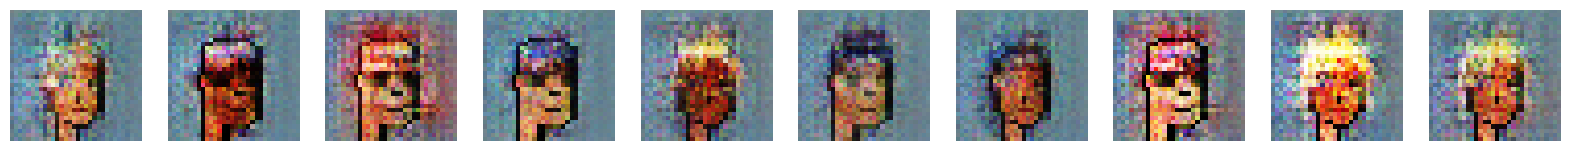

313/313 [==============================] - 12s 39ms/step - d_loss: 0.2593 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9823 - g_loss: 2.9476 - g_acc: 1.0000
Epoch 3/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2300 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9922 - g_loss: 3.0178 - g_acc: 1.0000
Saved to ./output/generated_img_002.png


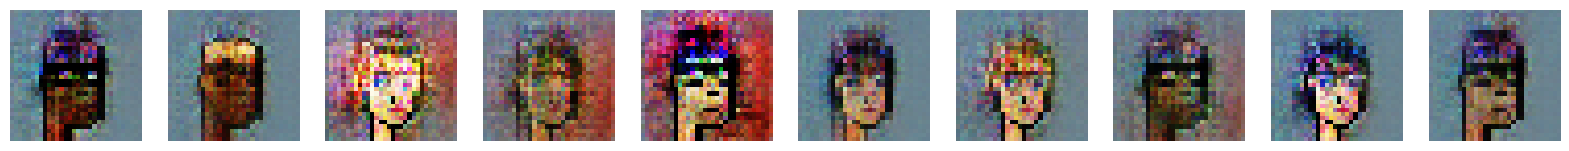

313/313 [==============================] - 11s 35ms/step - d_loss: 0.2300 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9922 - g_loss: 3.0178 - g_acc: 1.0000
Epoch 4/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2384 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9889 - g_loss: 3.0334 - g_acc: 1.0000
Saved to ./output/generated_img_003.png


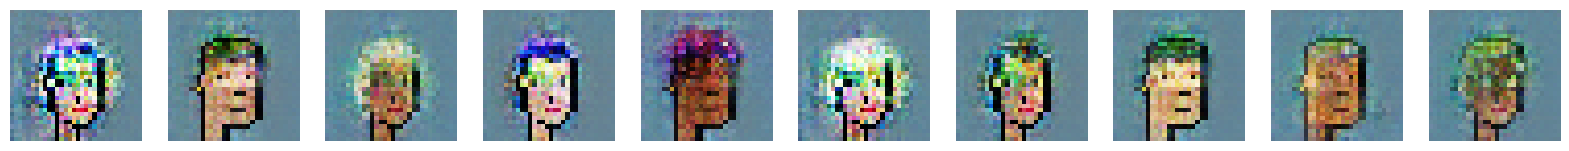

313/313 [==============================] - 13s 39ms/step - d_loss: 0.2384 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9889 - g_loss: 3.0334 - g_acc: 1.0000
Epoch 5/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2323 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9881 - g_loss: 3.0183 - g_acc: 1.0000
Saved to ./output/generated_img_004.png


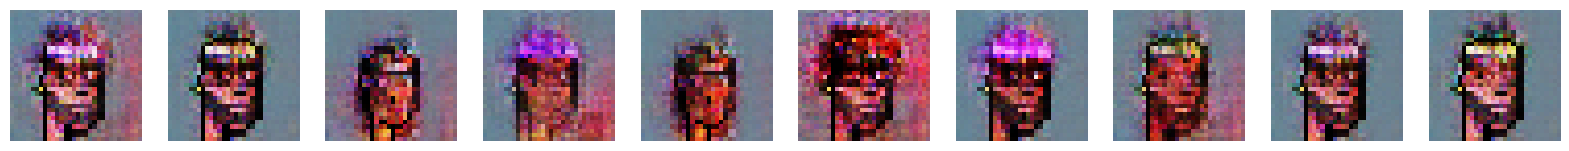

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2323 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9881 - g_loss: 3.0204 - g_acc: 1.0000
Epoch 6/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2186 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9976 - g_loss: 3.0762 - g_acc: 1.0000
Saved to ./output/generated_img_005.png


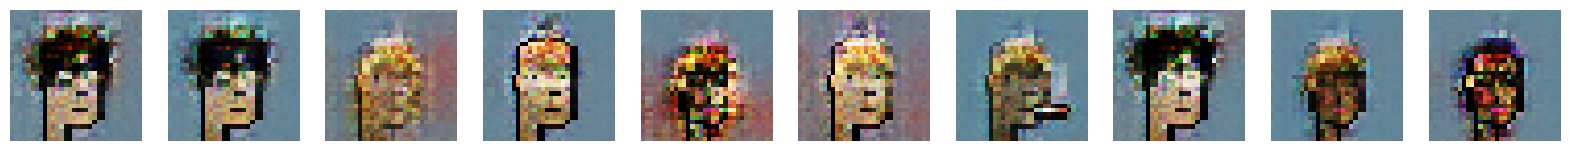

313/313 [==============================] - 12s 37ms/step - d_loss: 0.2186 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9976 - g_loss: 3.0789 - g_acc: 1.0000
Epoch 7/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2278 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9914 - g_loss: 3.0196 - g_acc: 1.0000
Saved to ./output/generated_img_006.png


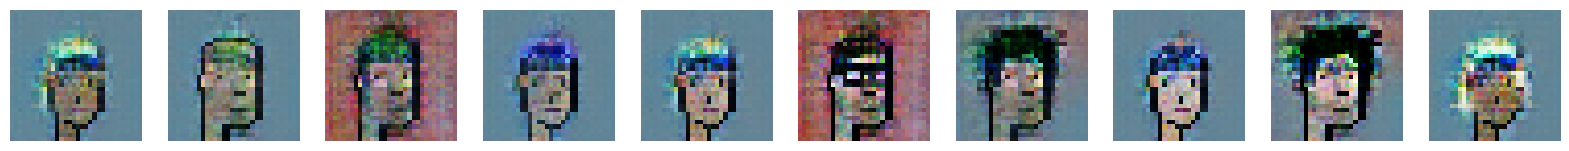

313/313 [==============================] - 13s 42ms/step - d_loss: 0.2278 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9914 - g_loss: 3.0196 - g_acc: 1.0000
Epoch 8/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2268 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9933 - g_loss: 3.0482 - g_acc: 1.0000
Saved to ./output/generated_img_007.png


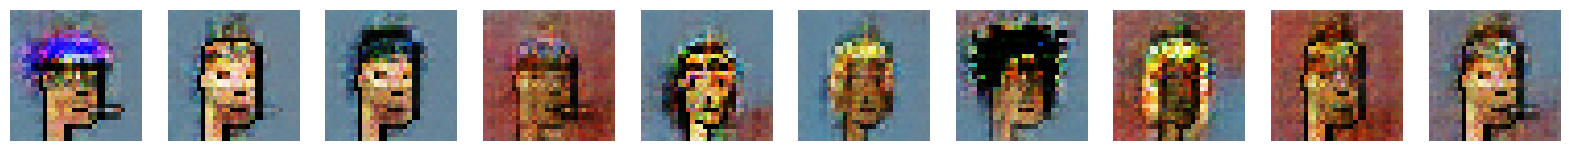

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2268 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9933 - g_loss: 3.0468 - g_acc: 1.0000
Epoch 9/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2108 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9995 - g_loss: 3.0597 - g_acc: 1.0000
Saved to ./output/generated_img_008.png


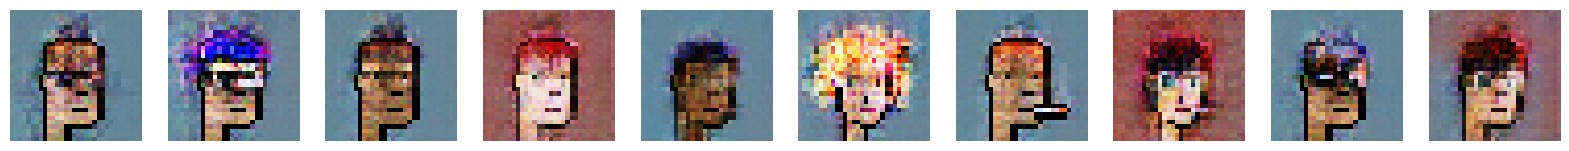

313/313 [==============================] - 13s 41ms/step - d_loss: 0.2108 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9995 - g_loss: 3.0597 - g_acc: 1.0000
Epoch 10/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2193 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9956 - g_loss: 3.0539 - g_acc: 1.0000
Saved to ./output/generated_img_009.png


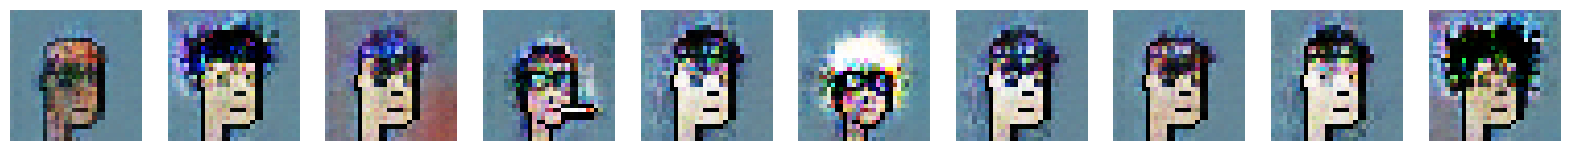

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2193 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9956 - g_loss: 3.0539 - g_acc: 1.0000
Epoch 11/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2158 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9972 - g_loss: 3.0651 - g_acc: 1.0000
Saved to ./output/generated_img_010.png


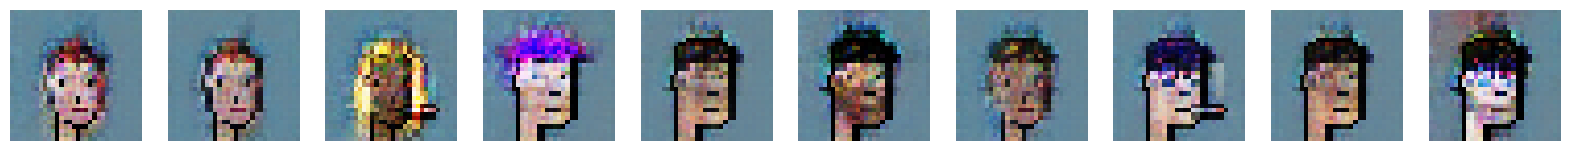

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2159 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9972 - g_loss: 3.0656 - g_acc: 1.0000
Epoch 12/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2117 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9961 - g_loss: 3.0134 - g_acc: 1.0000
Saved to ./output/generated_img_011.png


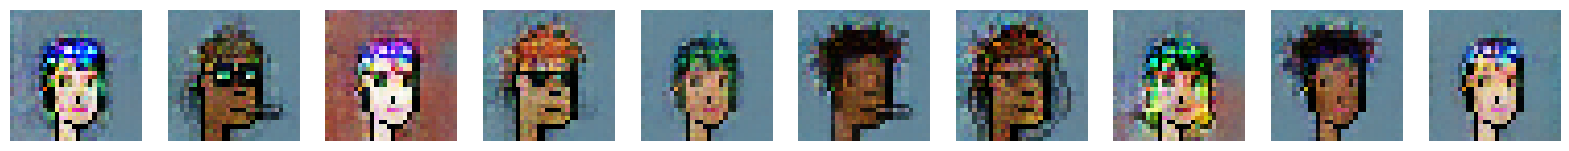

313/313 [==============================] - 13s 42ms/step - d_loss: 0.2118 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9961 - g_loss: 3.0099 - g_acc: 1.0000
Epoch 13/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2146 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9971 - g_loss: 3.0234 - g_acc: 1.0000
Saved to ./output/generated_img_012.png


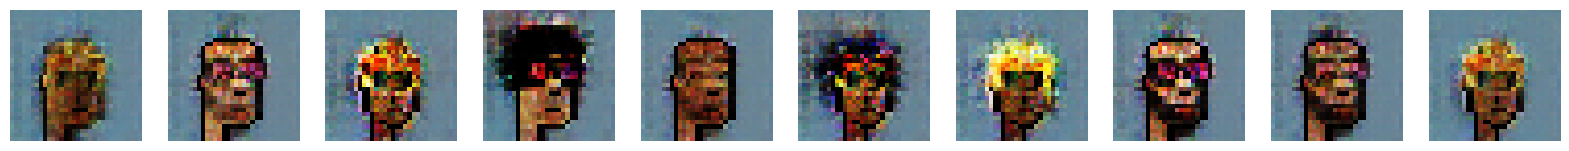

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2146 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9971 - g_loss: 3.0234 - g_acc: 1.0000
Epoch 14/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2141 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9975 - g_loss: 3.0437 - g_acc: 1.0000
Saved to ./output/generated_img_013.png


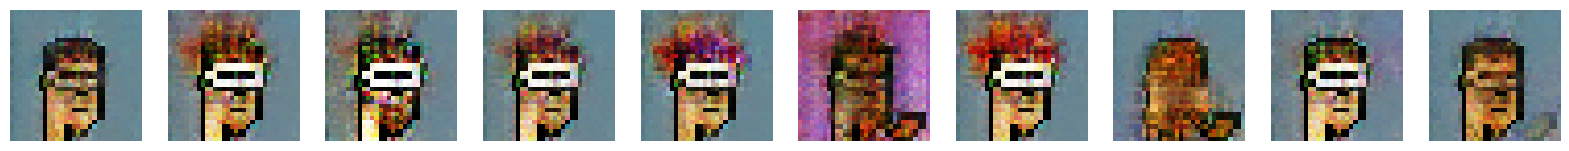

313/313 [==============================] - 13s 42ms/step - d_loss: 0.2140 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9975 - g_loss: 3.0435 - g_acc: 1.0000
Epoch 15/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2094 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9983 - g_loss: 3.0460 - g_acc: 1.0000
Saved to ./output/generated_img_014.png


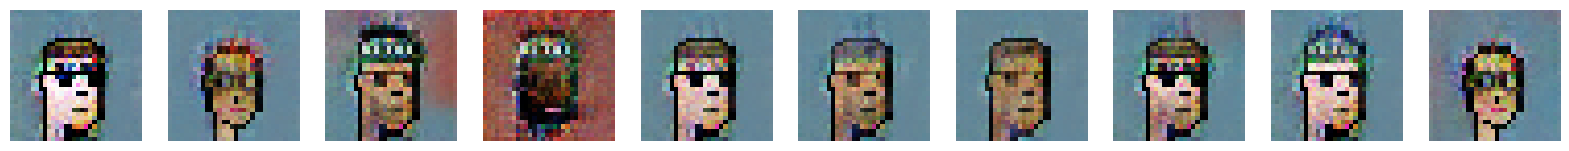

313/313 [==============================] - 12s 37ms/step - d_loss: 0.2095 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9983 - g_loss: 3.0441 - g_acc: 1.0000
Epoch 16/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2112 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9965 - g_loss: 3.0018 - g_acc: 1.0000
Saved to ./output/generated_img_015.png


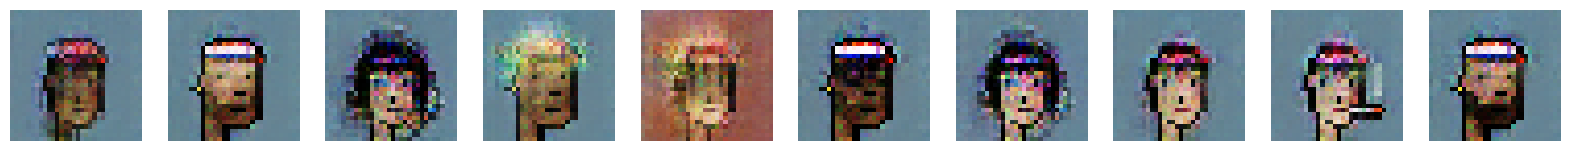

313/313 [==============================] - 13s 42ms/step - d_loss: 0.2112 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9965 - g_loss: 3.0018 - g_acc: 1.0000
Epoch 17/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2149 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9958 - g_loss: 3.0203 - g_acc: 1.0000
Saved to ./output/generated_img_016.png


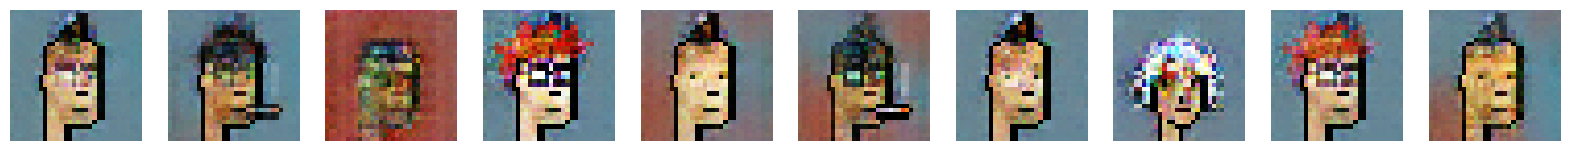

313/313 [==============================] - 12s 39ms/step - d_loss: 0.2148 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9958 - g_loss: 3.0220 - g_acc: 1.0000
Epoch 18/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2146 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9947 - g_loss: 3.0708 - g_acc: 1.0000
Saved to ./output/generated_img_017.png


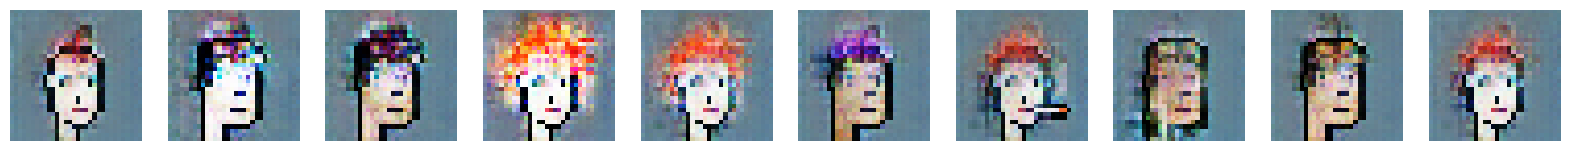

313/313 [==============================] - 14s 43ms/step - d_loss: 0.2146 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9947 - g_loss: 3.0708 - g_acc: 1.0000
Epoch 19/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2065 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9990 - g_loss: 3.0428 - g_acc: 1.0000
Saved to ./output/generated_img_018.png


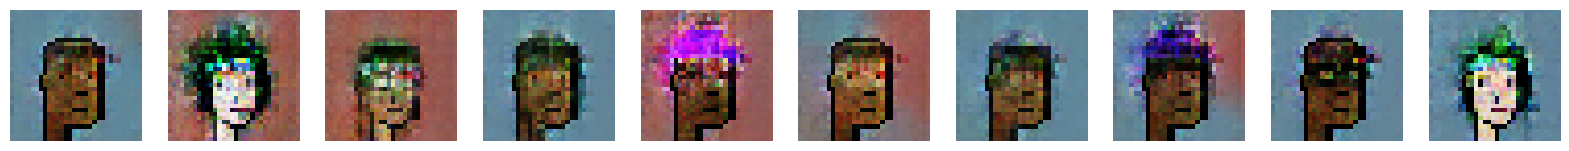

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2068 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9990 - g_loss: 3.0430 - g_acc: 1.0000
Epoch 20/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2089 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9983 - g_loss: 3.0155 - g_acc: 1.0000
Saved to ./output/generated_img_019.png


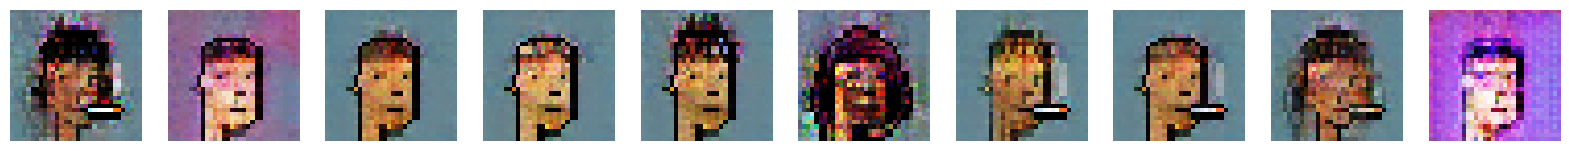

313/313 [==============================] - 14s 43ms/step - d_loss: 0.2089 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9983 - g_loss: 3.0155 - g_acc: 1.0000
Epoch 21/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2077 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9994 - g_loss: 3.0684 - g_acc: 1.0000
Saved to ./output/generated_img_020.png


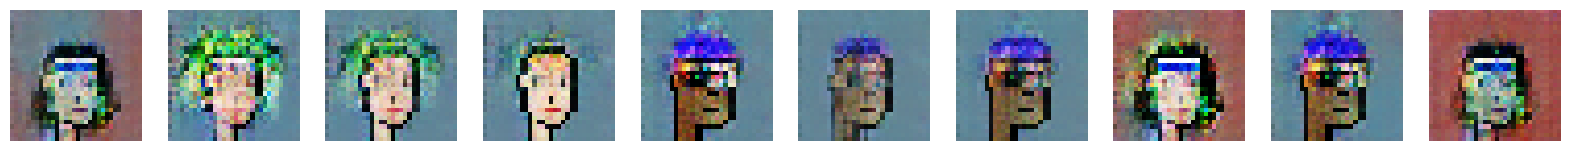

313/313 [==============================] - 13s 42ms/step - d_loss: 0.2077 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9994 - g_loss: 3.0693 - g_acc: 1.0000
Epoch 22/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2041 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0509 - g_acc: 1.0000
Saved to ./output/generated_img_021.png


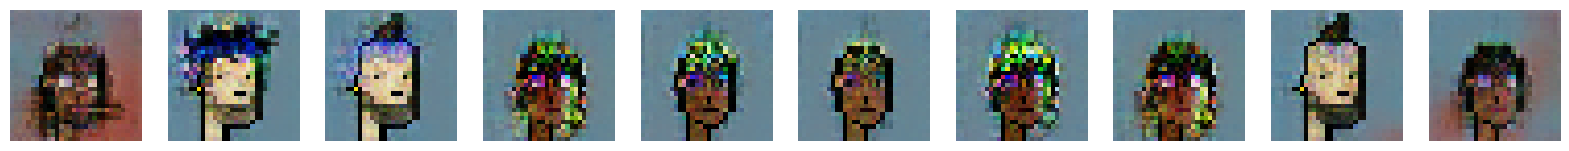

313/313 [==============================] - 14s 43ms/step - d_loss: 0.2041 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0513 - g_acc: 1.0000
Epoch 23/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2095 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9986 - g_loss: 3.0305 - g_acc: 1.0000
Saved to ./output/generated_img_022.png


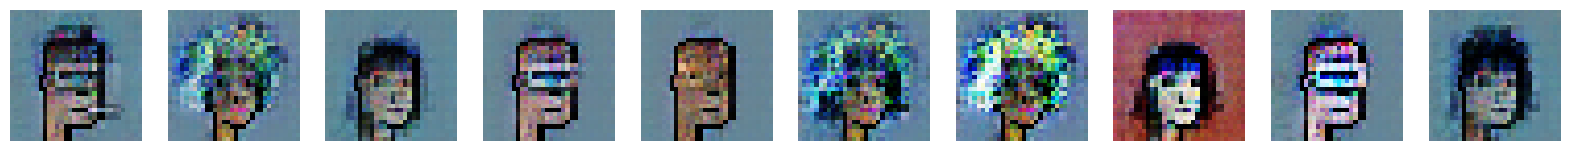

313/313 [==============================] - 14s 44ms/step - d_loss: 0.2095 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9986 - g_loss: 3.0305 - g_acc: 1.0000
Epoch 24/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2040 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0405 - g_acc: 1.0000
Saved to ./output/generated_img_023.png


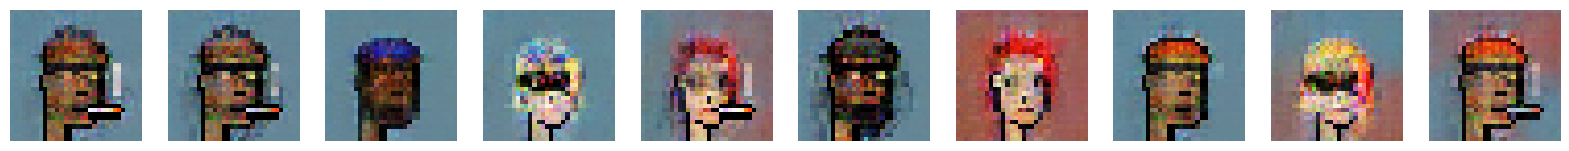

313/313 [==============================] - 13s 41ms/step - d_loss: 0.2040 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0419 - g_acc: 1.0000
Epoch 25/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2088 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9992 - g_loss: 3.0336 - g_acc: 1.0000
Saved to ./output/generated_img_024.png


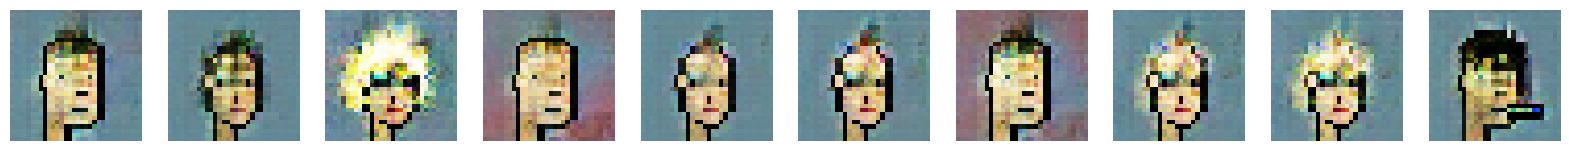

313/313 [==============================] - 13s 41ms/step - d_loss: 0.2088 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9992 - g_loss: 3.0336 - g_acc: 1.0000
Epoch 26/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2043 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0564 - g_acc: 1.0000
Saved to ./output/generated_img_025.png


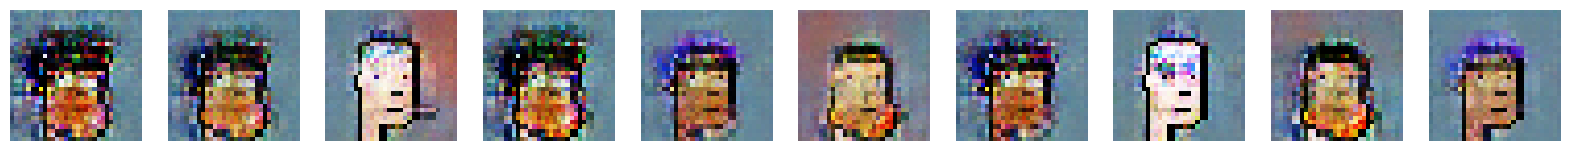

313/313 [==============================] - 12s 38ms/step - d_loss: 0.2044 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0567 - g_acc: 1.0000
Epoch 27/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2041 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0305 - g_acc: 1.0000
Saved to ./output/generated_img_026.png


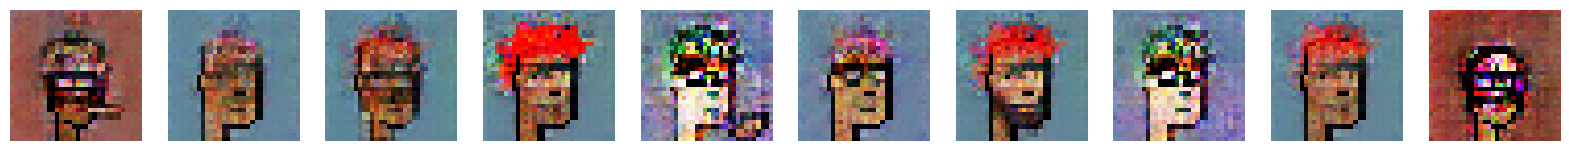

313/313 [==============================] - 14s 44ms/step - d_loss: 0.2040 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0300 - g_acc: 1.0000
Epoch 28/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2044 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9987 - g_loss: 3.0137 - g_acc: 1.0000
Saved to ./output/generated_img_027.png


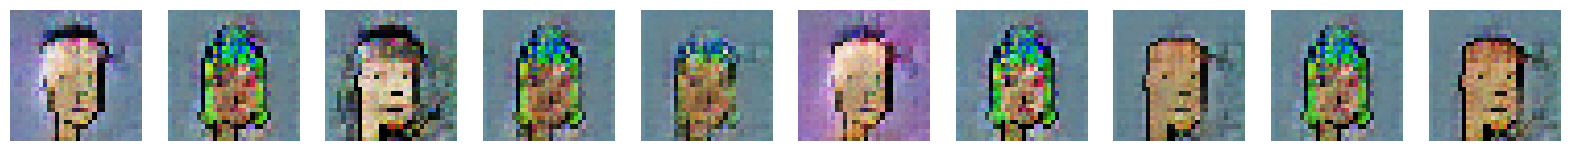

313/313 [==============================] - 13s 40ms/step - d_loss: 0.2044 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9987 - g_loss: 3.0147 - g_acc: 1.0000
Epoch 29/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2075 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9975 - g_loss: 2.9967 - g_acc: 1.0000
Saved to ./output/generated_img_028.png


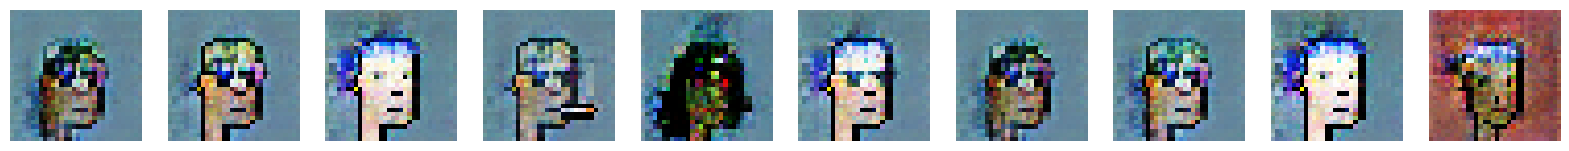

313/313 [==============================] - 15s 47ms/step - d_loss: 0.2074 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9975 - g_loss: 2.9960 - g_acc: 1.0000
Epoch 30/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2091 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9966 - g_loss: 2.9698 - g_acc: 1.0000
Saved to ./output/generated_img_029.png


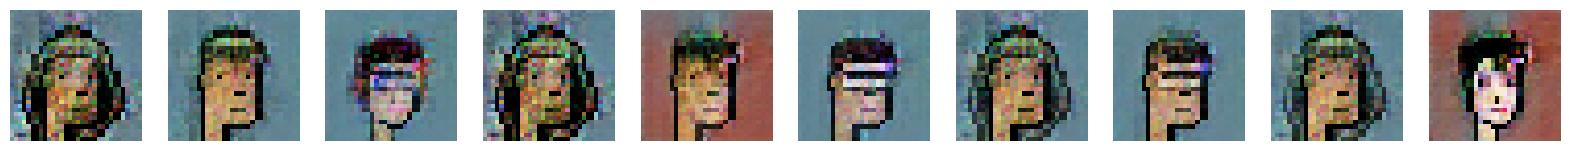

313/313 [==============================] - 14s 43ms/step - d_loss: 0.2091 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9966 - g_loss: 2.9692 - g_acc: 1.0000
Epoch 31/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2068 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9971 - g_loss: 3.0191 - g_acc: 1.0000
Saved to ./output/generated_img_030.png


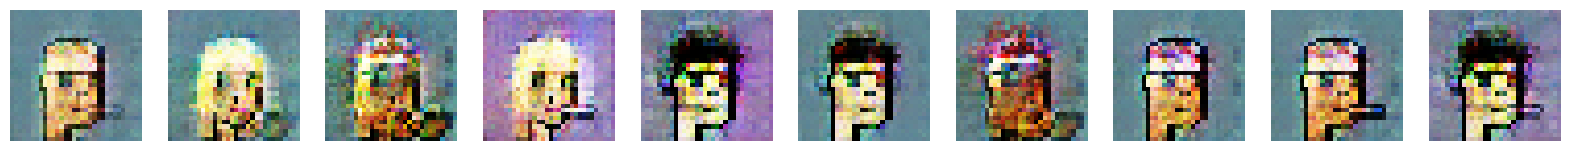

313/313 [==============================] - 12s 39ms/step - d_loss: 0.2068 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9971 - g_loss: 3.0191 - g_acc: 1.0000
Epoch 32/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2062 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9993 - g_loss: 3.0158 - g_acc: 1.0000
Saved to ./output/generated_img_031.png


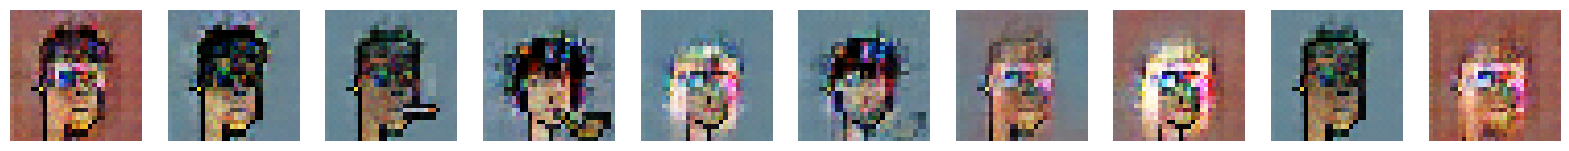

313/313 [==============================] - 14s 45ms/step - d_loss: 0.2062 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9993 - g_loss: 3.0156 - g_acc: 1.0000
Epoch 33/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2031 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0216 - g_acc: 1.0000
Saved to ./output/generated_img_032.png


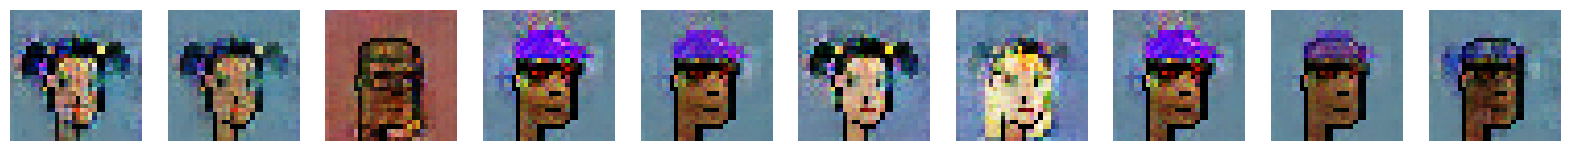

313/313 [==============================] - 15s 46ms/step - d_loss: 0.2031 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0229 - g_acc: 1.0000
Epoch 34/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2010 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0327 - g_acc: 1.0000
Saved to ./output/generated_img_033.png


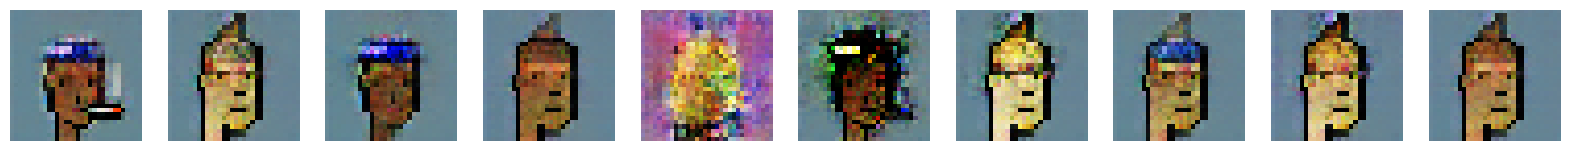

313/313 [==============================] - 15s 46ms/step - d_loss: 0.2010 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0321 - g_acc: 1.0000
Epoch 35/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2090 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9967 - g_loss: 2.9796 - g_acc: 1.0000
Saved to ./output/generated_img_034.png


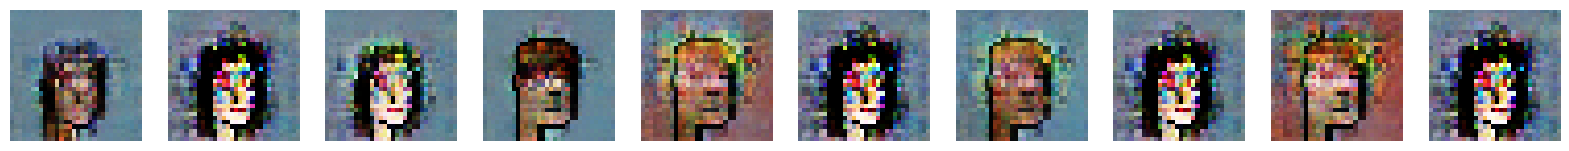

313/313 [==============================] - 13s 42ms/step - d_loss: 0.2090 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9967 - g_loss: 2.9796 - g_acc: 1.0000
Epoch 36/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2070 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9982 - g_loss: 3.0001 - g_acc: 1.0000
Saved to ./output/generated_img_035.png


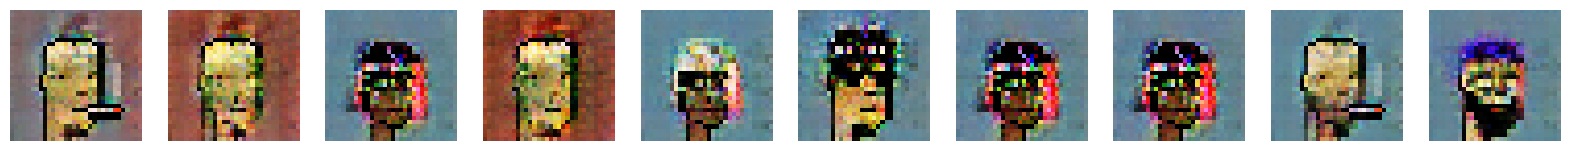

313/313 [==============================] - 14s 45ms/step - d_loss: 0.2070 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9982 - g_loss: 2.9997 - g_acc: 1.0000
Epoch 37/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2069 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9969 - g_loss: 2.9908 - g_acc: 1.0000
Saved to ./output/generated_img_036.png


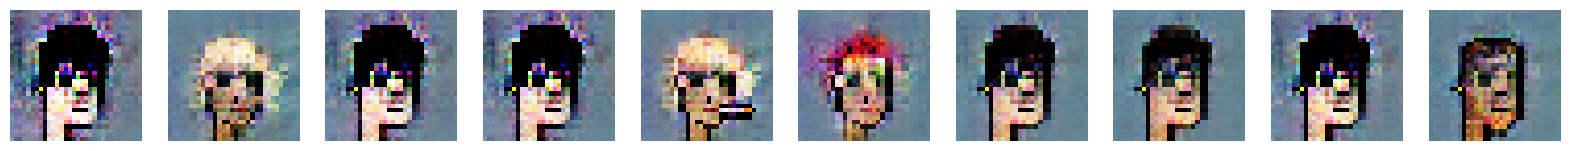

313/313 [==============================] - 15s 47ms/step - d_loss: 0.2069 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9969 - g_loss: 2.9889 - g_acc: 1.0000
Epoch 38/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2089 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9952 - g_loss: 2.9966 - g_acc: 1.0000
Saved to ./output/generated_img_037.png


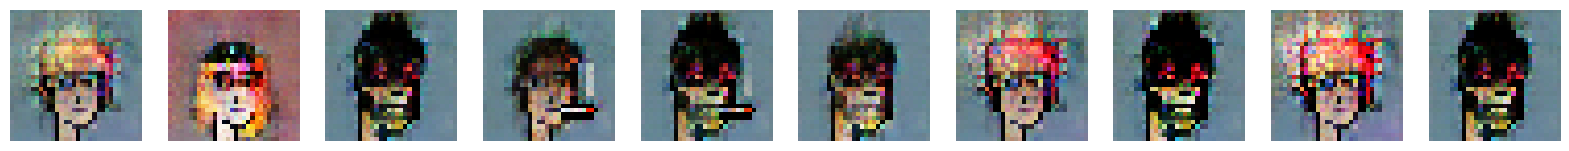

313/313 [==============================] - 15s 47ms/step - d_loss: 0.2088 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9952 - g_loss: 2.9952 - g_acc: 1.0000
Epoch 39/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2007 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0212 - g_acc: 1.0000
Saved to ./output/generated_img_038.png


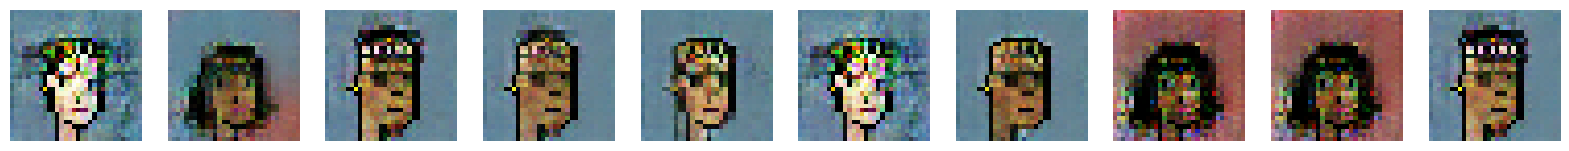

313/313 [==============================] - 15s 46ms/step - d_loss: 0.2006 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0223 - g_acc: 1.0000
Epoch 40/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2042 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0224 - g_acc: 1.0000
Saved to ./output/generated_img_039.png


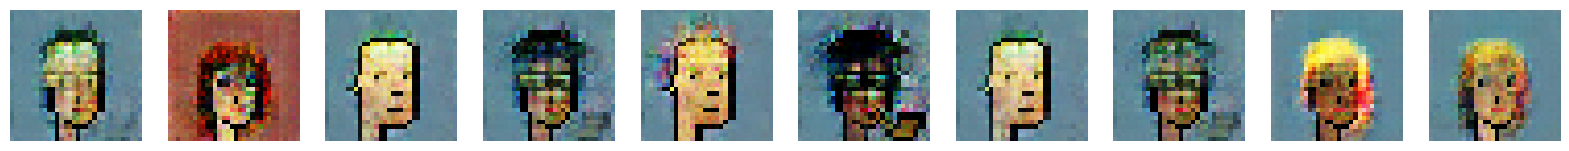

313/313 [==============================] - 19s 60ms/step - d_loss: 0.2042 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0224 - g_acc: 1.0000
Epoch 41/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2044 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9987 - g_loss: 3.0191 - g_acc: 1.0000
Saved to ./output/generated_img_040.png


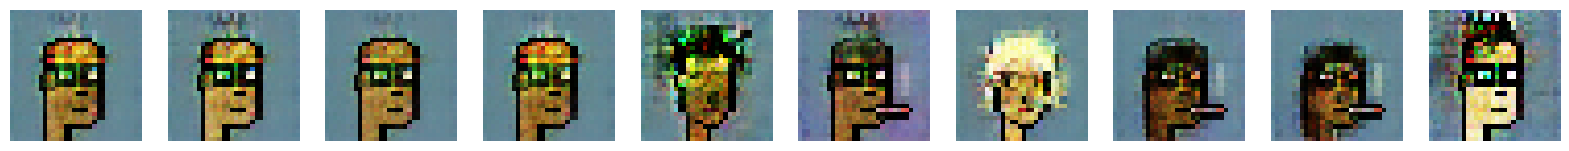

313/313 [==============================] - 16s 51ms/step - d_loss: 0.2044 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9987 - g_loss: 3.0191 - g_acc: 1.0000
Epoch 42/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2037 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9984 - g_loss: 3.0017 - g_acc: 1.0000
Saved to ./output/generated_img_041.png


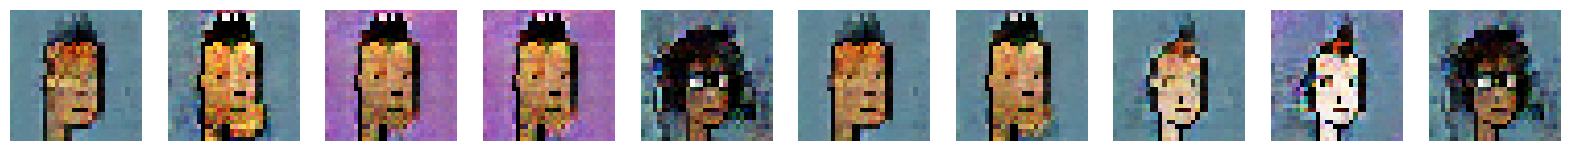

313/313 [==============================] - 19s 60ms/step - d_loss: 0.2037 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9984 - g_loss: 3.0032 - g_acc: 1.0000
Epoch 43/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2015 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9997 - g_loss: 3.0167 - g_acc: 1.0000
Saved to ./output/generated_img_042.png


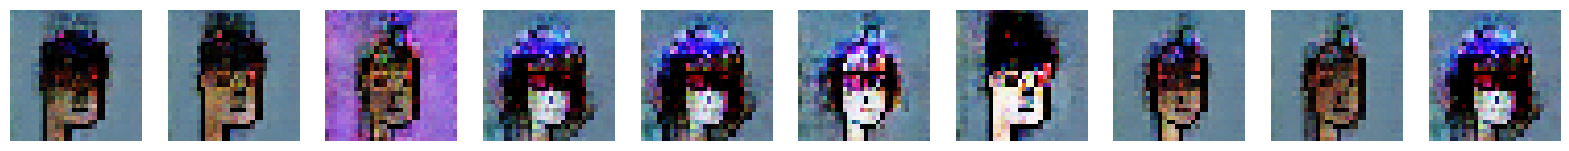

313/313 [==============================] - 17s 54ms/step - d_loss: 0.2018 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9997 - g_loss: 3.0125 - g_acc: 1.0000
Epoch 44/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2013 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0176 - g_acc: 1.0000
Saved to ./output/generated_img_043.png


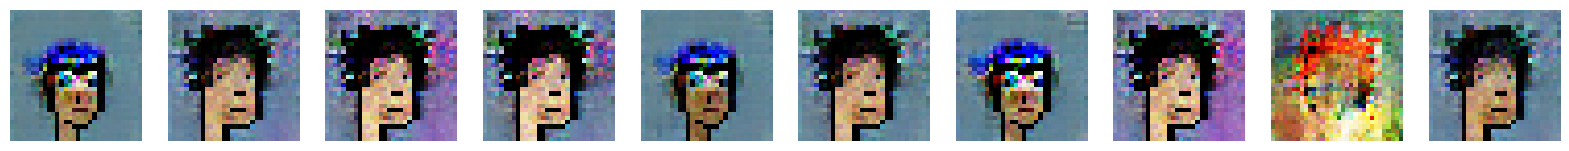

313/313 [==============================] - 22s 69ms/step - d_loss: 0.2013 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0172 - g_acc: 1.0000
Epoch 45/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2069 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9981 - g_loss: 3.0291 - g_acc: 1.0000
Saved to ./output/generated_img_044.png


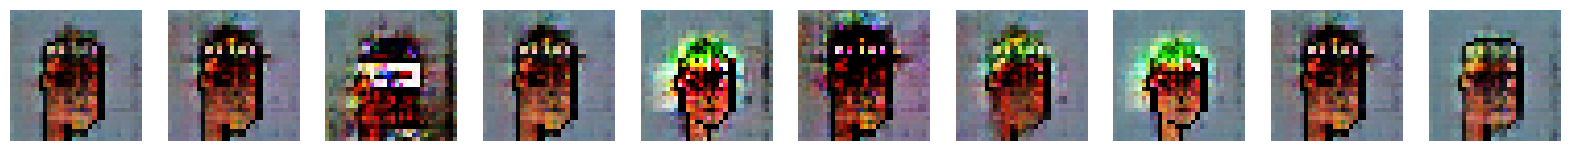

313/313 [==============================] - 16s 50ms/step - d_loss: 0.2069 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9981 - g_loss: 3.0291 - g_acc: 1.0000
Epoch 46/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2019 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0151 - g_acc: 1.0000
Saved to ./output/generated_img_045.png


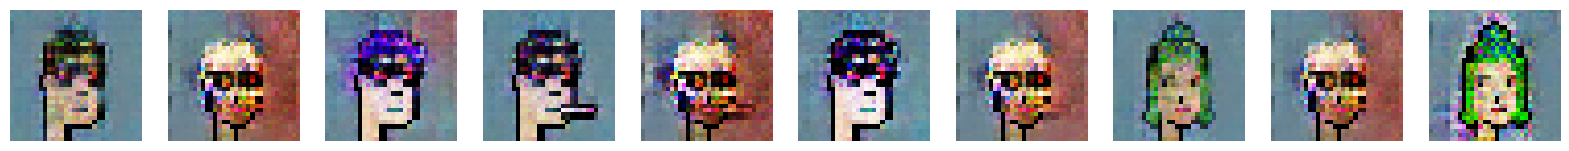

313/313 [==============================] - 17s 55ms/step - d_loss: 0.2019 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0152 - g_acc: 1.0000
Epoch 47/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2018 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0085 - g_acc: 1.0000
Saved to ./output/generated_img_046.png


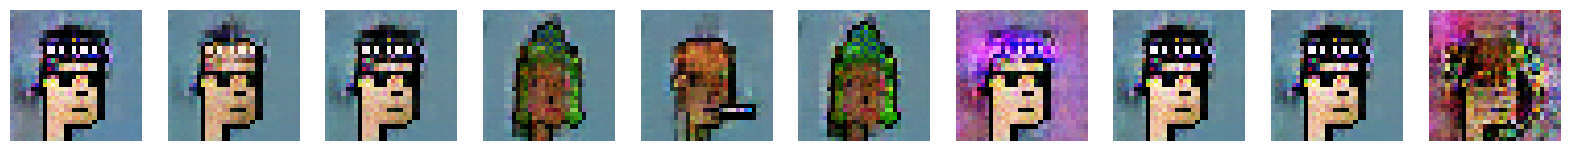

313/313 [==============================] - 18s 56ms/step - d_loss: 0.2018 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9999 - g_loss: 3.0085 - g_acc: 1.0000
Epoch 48/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2004 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0123 - g_acc: 1.0000
Saved to ./output/generated_img_047.png


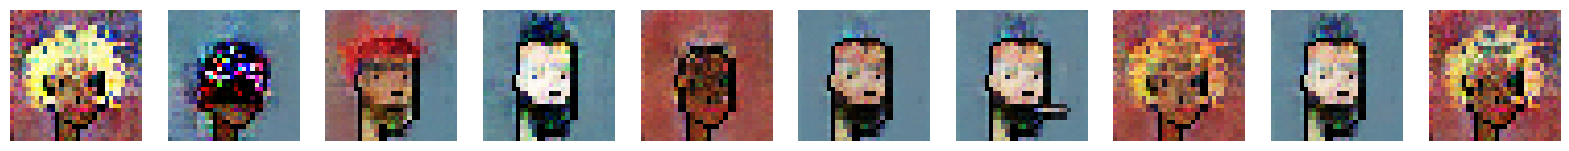

313/313 [==============================] - 15s 46ms/step - d_loss: 0.2004 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 1.0000 - g_loss: 3.0097 - g_acc: 1.0000
Epoch 49/50
312/313 [============================>.] - ETA: 0s - d_loss: 0.2033 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9995 - g_loss: 3.0045 - g_acc: 1.0000
Saved to ./output/generated_img_048.png


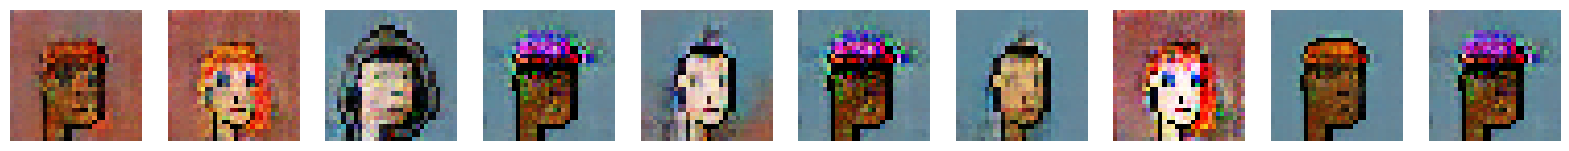

313/313 [==============================] - 17s 54ms/step - d_loss: 0.2033 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9995 - g_loss: 3.0050 - g_acc: 1.0000
Epoch 50/50
313/313 [==============================] - ETA: 0s - d_loss: 0.2047 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9984 - g_loss: 2.9827 - g_acc: 1.0000
Saved to ./output/generated_img_049.png


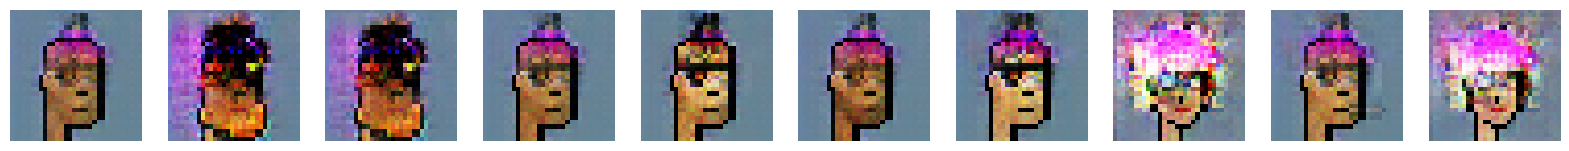

313/313 [==============================] - 15s 46ms/step - d_loss: 0.2047 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.9984 - g_loss: 2.9827 - g_acc: 1.0000


In [38]:
dcgan3.fit(
    train,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=100),
    ],
)

### DCGAN generated images

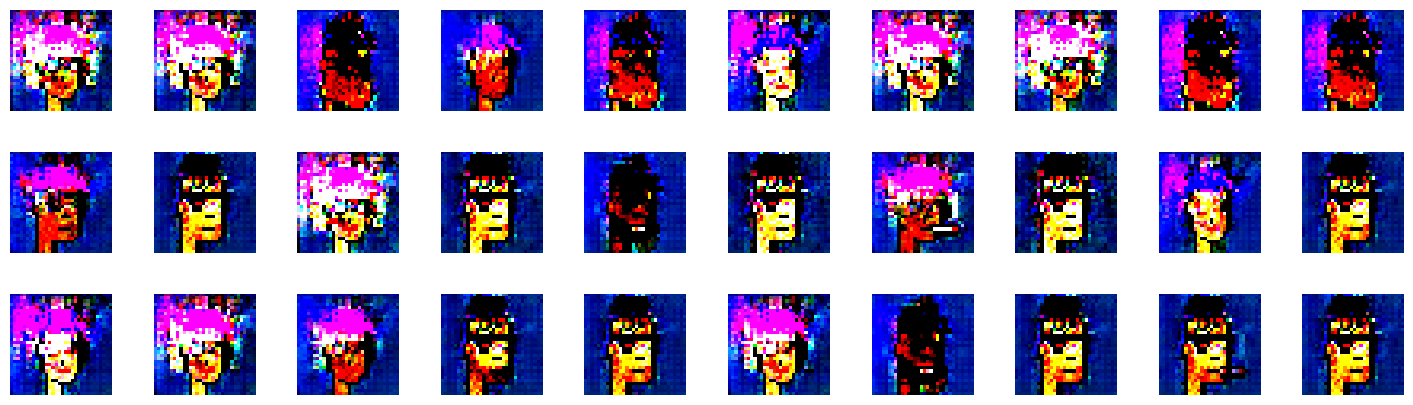

In [54]:
grid_width, grid_height = (10,3)
z_sample= np.random.normal(size=(grid_height* grid_width, 100))
reconstructions = generator.predict(z_sample)

def adjust_brightness(image, factor=1.5):
    adjusted_image = np.clip(image * factor, 0.0, 1.0)
    return adjusted_image

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")

    adjusted_image = adjust_brightness(reconstructions[i, :, :], 3)
    ax.imshow(adjusted_image)

plt.show()


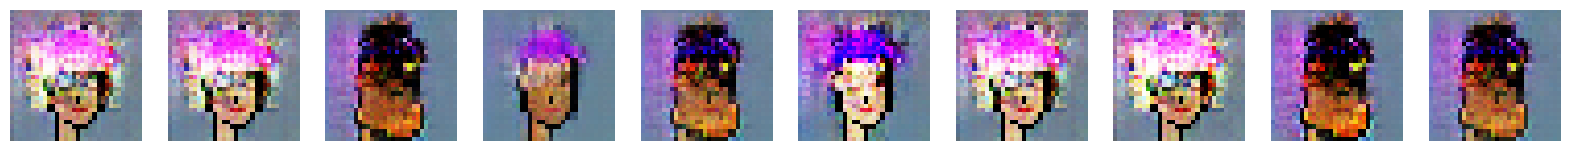

In [59]:
display(reconstructions)

In [40]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [41]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [42]:
all_data.shape

(9999, 32, 32, 3)

#### Similar images in dataset

1/1 [==============================] - 0s 23ms/step


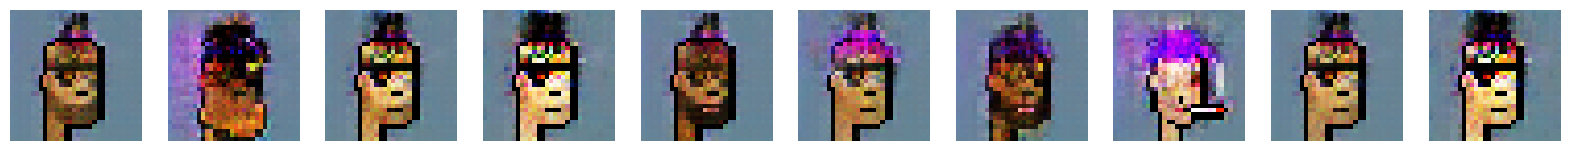

In [60]:
r, c = 3, 5
# fig, axs = plt.subplots(r, c, figsize=(10, 6))
# fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, 100))
gen_imgs = generator.predict(noise)

# cnt = 0
# for i in range(r):
#     for j in range(c):
#         axs[i, j].imshow(tf.cast(gen_imgs[cnt], "float32"), cmap=None)
#         axs[i, j].axis("off")
#         cnt += 1

# plt.show()
display(gen_imgs)

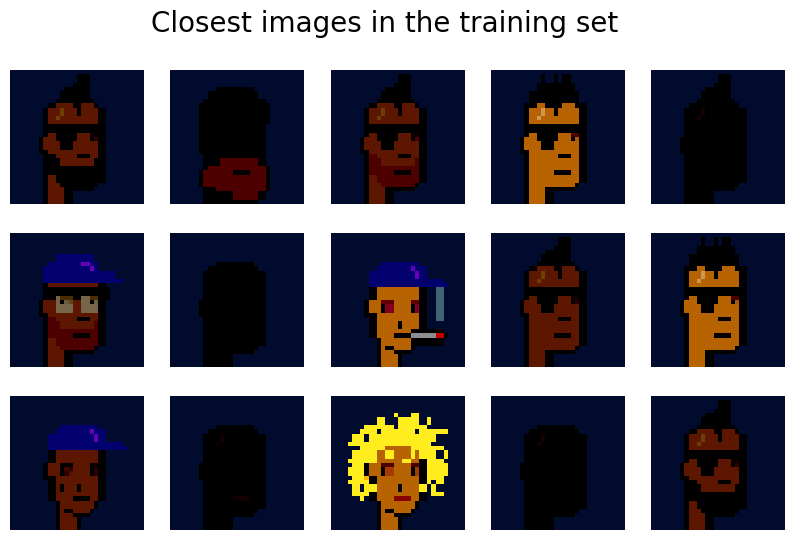

In [64]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap=None)
        axs[i, j].axis("off")
        cnt += 1

plt.show()

## WGAN-GP

In [65]:
critic_input = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(critic_input)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

critic_output = layers.Dense(1)(x)

critic = models.Model(critic_input, critic_output)
critic.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 layer_normalization (Layer  (None, 8, 8, 128)         256       
 Normalization)                                                  
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                           

Using same generator

In [66]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [67]:
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=100,
    critic_steps=3,
    gp_weight=10,
)

In [68]:
wgangp.compile(
    c_optimizer = optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5, beta_2 = 0.99),
    g_optimizer = optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.99),
)

In [69]:
class ImageGenerator_wgan(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output_wgan/generated_img_%03d.png" % (epoch),
            cmap=None,
        )

In [70]:
!mkdir output_wgan/

Epoch 1/50
313/313 [==============================] - ETA: 0s - c_loss: -12.3801 - c_wass_loss: -15.3844 - c_gp: 0.3004 - g_loss: 9.0720
Saved to ./output_wgan/generated_img_000.png


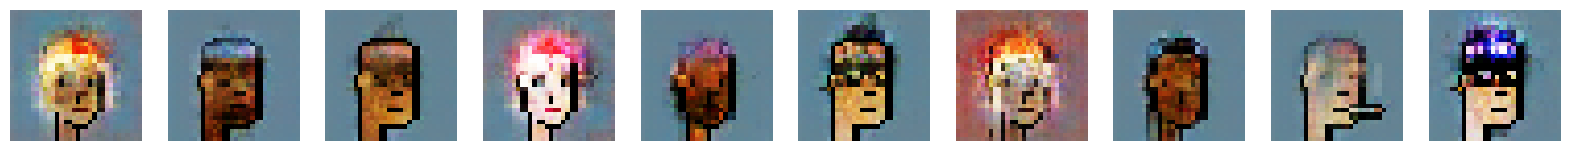

313/313 [==============================] - 67s 147ms/step - c_loss: -12.3801 - c_wass_loss: -15.3844 - c_gp: 0.3004 - g_loss: 9.0720
Epoch 2/50
313/313 [==============================] - ETA: 0s - c_loss: -13.3963 - c_wass_loss: -16.5233 - c_gp: 0.3127 - g_loss: 11.0743
Saved to ./output_wgan/generated_img_001.png


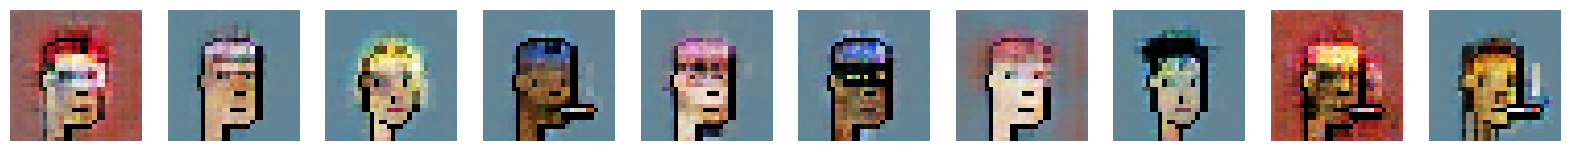

313/313 [==============================] - 45s 144ms/step - c_loss: -13.3963 - c_wass_loss: -16.5233 - c_gp: 0.3127 - g_loss: 11.0743
Epoch 3/50
313/313 [==============================] - ETA: 0s - c_loss: -13.6194 - c_wass_loss: -17.2168 - c_gp: 0.3597 - g_loss: 16.2850
Saved to ./output_wgan/generated_img_002.png


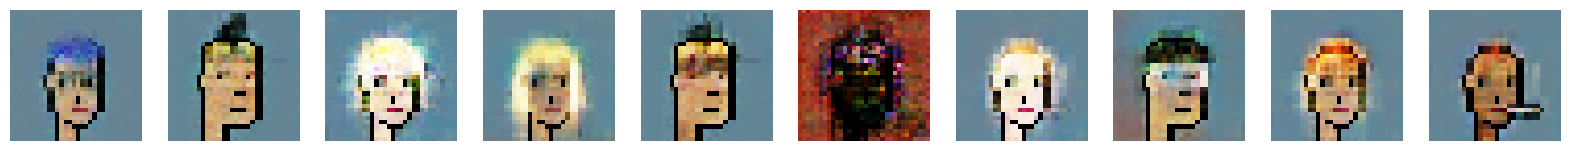

313/313 [==============================] - 46s 147ms/step - c_loss: -13.6194 - c_wass_loss: -17.2168 - c_gp: 0.3597 - g_loss: 16.2850
Epoch 4/50
313/313 [==============================] - ETA: 0s - c_loss: -13.5134 - c_wass_loss: -17.0759 - c_gp: 0.3562 - g_loss: 18.8156
Saved to ./output_wgan/generated_img_003.png


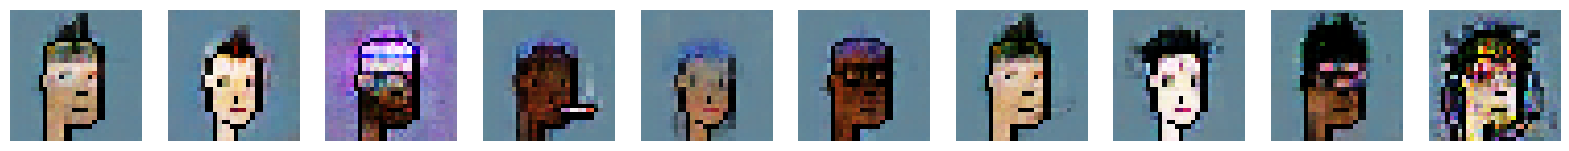

313/313 [==============================] - 46s 147ms/step - c_loss: -13.5134 - c_wass_loss: -17.0759 - c_gp: 0.3562 - g_loss: 18.8156
Epoch 5/50
313/313 [==============================] - ETA: 0s - c_loss: -13.3481 - c_wass_loss: -17.2073 - c_gp: 0.3859 - g_loss: 19.2258
Saved to ./output_wgan/generated_img_004.png


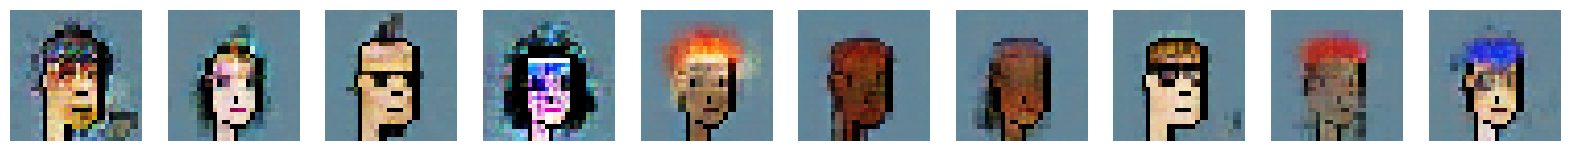

313/313 [==============================] - 46s 146ms/step - c_loss: -13.3481 - c_wass_loss: -17.2073 - c_gp: 0.3859 - g_loss: 19.2258
Epoch 6/50
313/313 [==============================] - ETA: 0s - c_loss: -13.6310 - c_wass_loss: -17.4014 - c_gp: 0.3770 - g_loss: 20.5219
Saved to ./output_wgan/generated_img_005.png


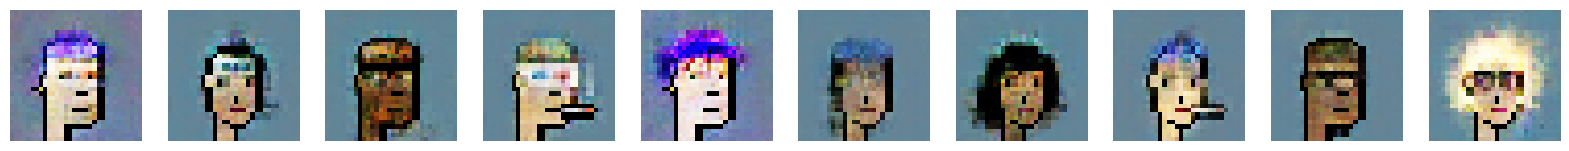

313/313 [==============================] - 46s 148ms/step - c_loss: -13.6310 - c_wass_loss: -17.4014 - c_gp: 0.3770 - g_loss: 20.5219
Epoch 7/50
313/313 [==============================] - ETA: 0s - c_loss: -13.6895 - c_wass_loss: -17.6934 - c_gp: 0.4004 - g_loss: 21.5465
Saved to ./output_wgan/generated_img_006.png


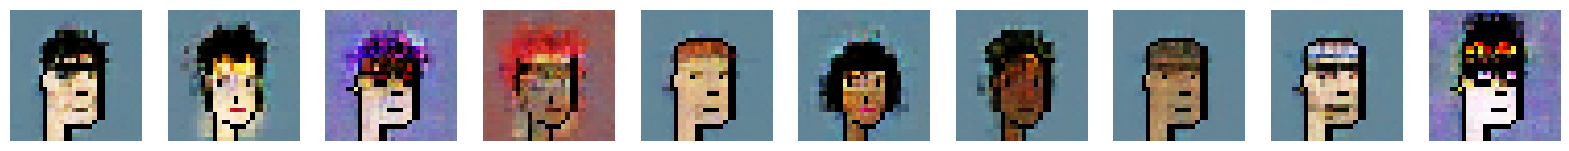

313/313 [==============================] - 48s 153ms/step - c_loss: -13.6895 - c_wass_loss: -17.6934 - c_gp: 0.4004 - g_loss: 21.5465
Epoch 8/50
313/313 [==============================] - ETA: 0s - c_loss: -13.4148 - c_wass_loss: -17.4536 - c_gp: 0.4039 - g_loss: 21.7054
Saved to ./output_wgan/generated_img_007.png


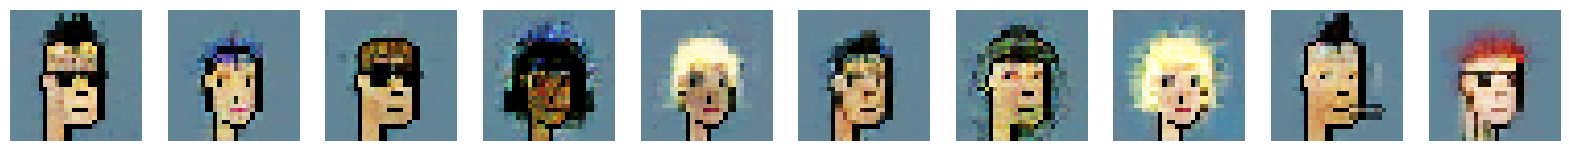

313/313 [==============================] - 48s 153ms/step - c_loss: -13.4148 - c_wass_loss: -17.4536 - c_gp: 0.4039 - g_loss: 21.7054
Epoch 9/50
313/313 [==============================] - ETA: 0s - c_loss: -13.4317 - c_wass_loss: -17.4968 - c_gp: 0.4065 - g_loss: 22.4665
Saved to ./output_wgan/generated_img_008.png


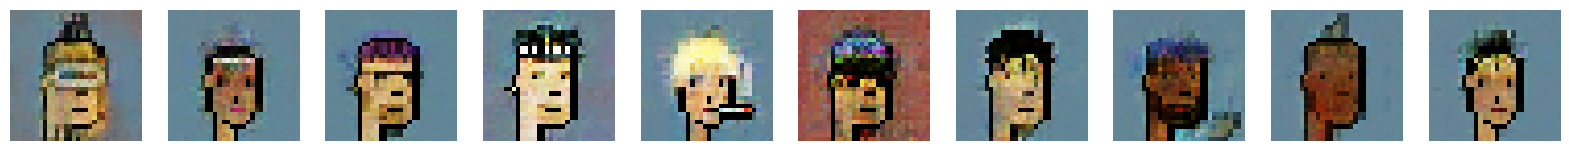

313/313 [==============================] - 49s 156ms/step - c_loss: -13.4317 - c_wass_loss: -17.4968 - c_gp: 0.4065 - g_loss: 22.4665
Epoch 10/50
313/313 [==============================] - ETA: 0s - c_loss: -13.3974 - c_wass_loss: -17.4214 - c_gp: 0.4024 - g_loss: 22.8691
Saved to ./output_wgan/generated_img_009.png


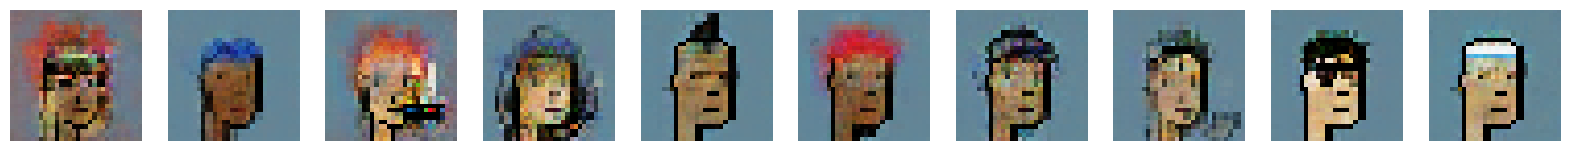

313/313 [==============================] - 47s 151ms/step - c_loss: -13.3974 - c_wass_loss: -17.4214 - c_gp: 0.4024 - g_loss: 22.8691
Epoch 11/50
313/313 [==============================] - ETA: 0s - c_loss: -13.2021 - c_wass_loss: -17.3843 - c_gp: 0.4182 - g_loss: 22.7163
Saved to ./output_wgan/generated_img_010.png


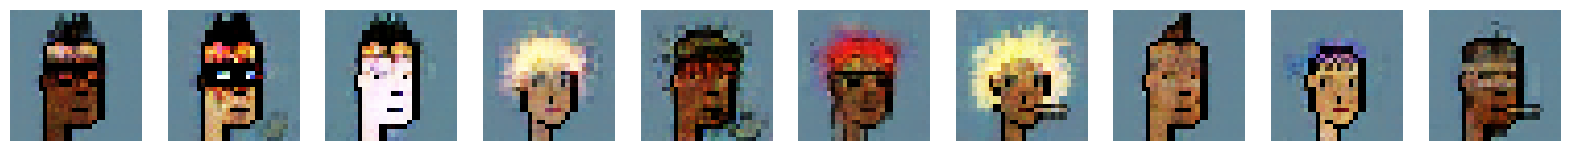

313/313 [==============================] - 48s 154ms/step - c_loss: -13.2021 - c_wass_loss: -17.3843 - c_gp: 0.4182 - g_loss: 22.7163
Epoch 12/50
313/313 [==============================] - ETA: 0s - c_loss: -13.2292 - c_wass_loss: -17.3659 - c_gp: 0.4137 - g_loss: 22.3691
Saved to ./output_wgan/generated_img_011.png


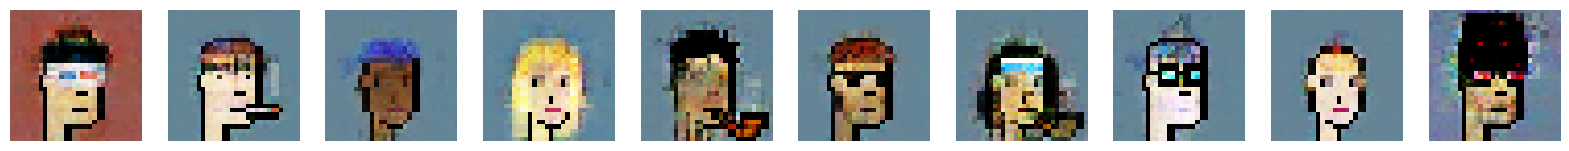

313/313 [==============================] - 48s 152ms/step - c_loss: -13.2292 - c_wass_loss: -17.3659 - c_gp: 0.4137 - g_loss: 22.3691
Epoch 13/50
313/313 [==============================] - ETA: 0s - c_loss: -13.0979 - c_wass_loss: -17.1686 - c_gp: 0.4071 - g_loss: 23.3956
Saved to ./output_wgan/generated_img_012.png


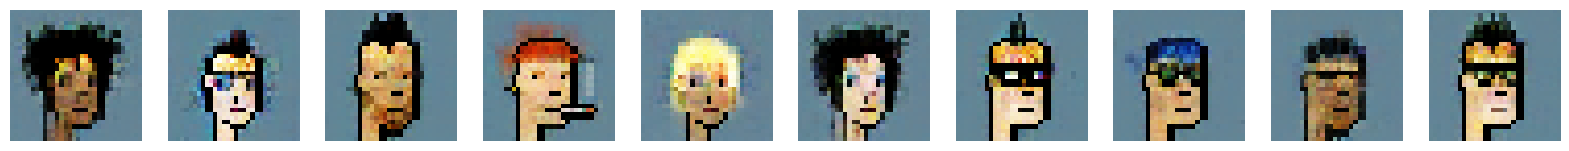

313/313 [==============================] - 48s 153ms/step - c_loss: -13.0979 - c_wass_loss: -17.1686 - c_gp: 0.4071 - g_loss: 23.3956
Epoch 14/50
313/313 [==============================] - ETA: 0s - c_loss: -12.9925 - c_wass_loss: -17.1189 - c_gp: 0.4126 - g_loss: 23.9993
Saved to ./output_wgan/generated_img_013.png


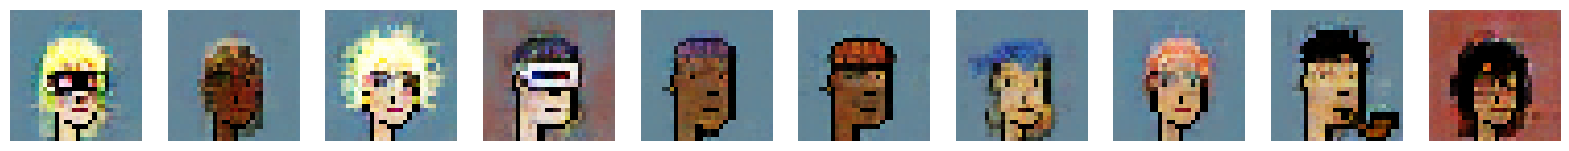

313/313 [==============================] - 49s 155ms/step - c_loss: -12.9925 - c_wass_loss: -17.1189 - c_gp: 0.4126 - g_loss: 23.9993
Epoch 15/50
313/313 [==============================] - ETA: 0s - c_loss: -12.8224 - c_wass_loss: -16.9137 - c_gp: 0.4091 - g_loss: 23.8024
Saved to ./output_wgan/generated_img_014.png


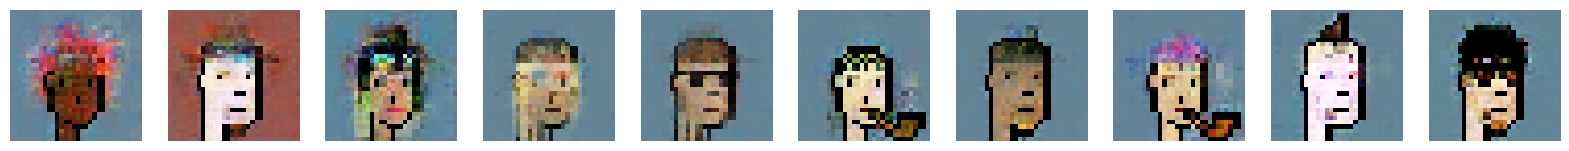

313/313 [==============================] - 48s 154ms/step - c_loss: -12.8224 - c_wass_loss: -16.9137 - c_gp: 0.4091 - g_loss: 23.8024
Epoch 16/50
313/313 [==============================] - ETA: 0s - c_loss: -12.8077 - c_wass_loss: -16.9103 - c_gp: 0.4103 - g_loss: 24.0528
Saved to ./output_wgan/generated_img_015.png


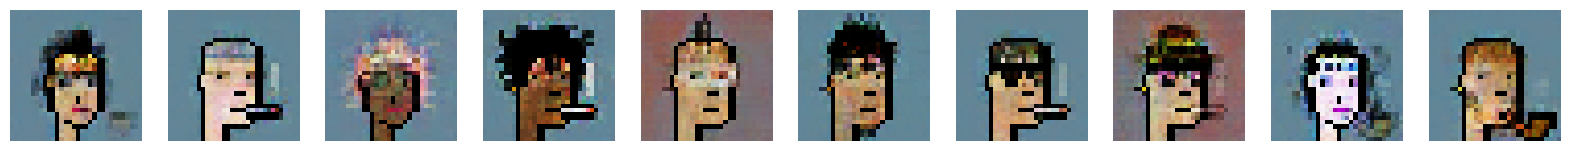

313/313 [==============================] - 48s 154ms/step - c_loss: -12.8077 - c_wass_loss: -16.9103 - c_gp: 0.4103 - g_loss: 24.0528
Epoch 17/50
313/313 [==============================] - ETA: 0s - c_loss: -12.9664 - c_wass_loss: -16.9125 - c_gp: 0.3946 - g_loss: 23.9363
Saved to ./output_wgan/generated_img_016.png


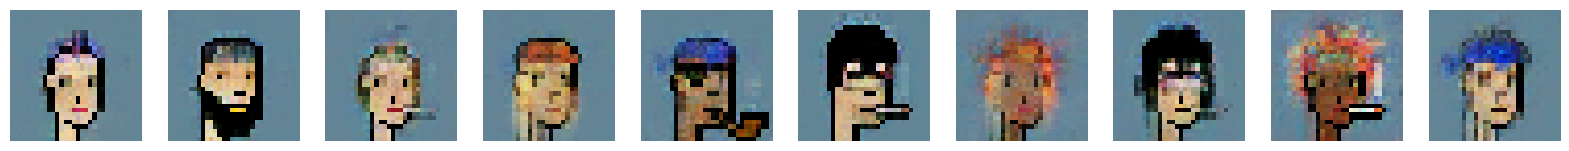

313/313 [==============================] - 49s 157ms/step - c_loss: -12.9664 - c_wass_loss: -16.9125 - c_gp: 0.3946 - g_loss: 23.9363
Epoch 18/50
313/313 [==============================] - ETA: 0s - c_loss: -12.6449 - c_wass_loss: -16.8456 - c_gp: 0.4201 - g_loss: 23.6308
Saved to ./output_wgan/generated_img_017.png


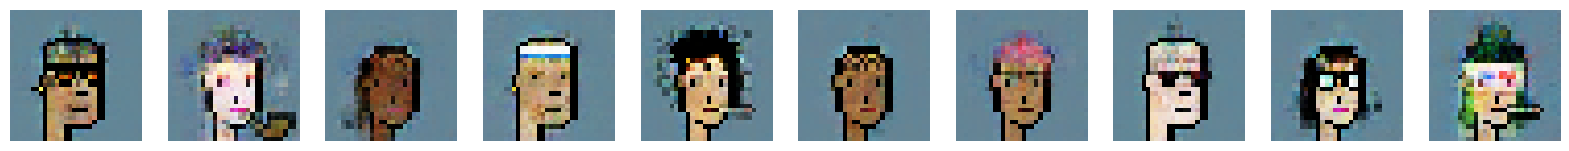

313/313 [==============================] - 49s 156ms/step - c_loss: -12.6449 - c_wass_loss: -16.8456 - c_gp: 0.4201 - g_loss: 23.6308
Epoch 19/50
313/313 [==============================] - ETA: 0s - c_loss: -12.4639 - c_wass_loss: -16.6189 - c_gp: 0.4155 - g_loss: 22.4843
Saved to ./output_wgan/generated_img_018.png


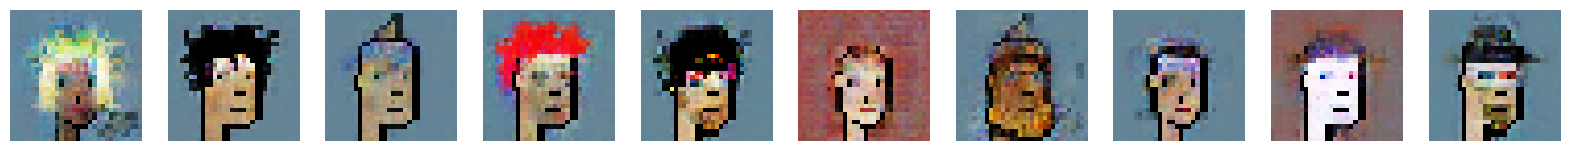

313/313 [==============================] - 49s 155ms/step - c_loss: -12.4639 - c_wass_loss: -16.6189 - c_gp: 0.4155 - g_loss: 22.4843
Epoch 20/50
313/313 [==============================] - ETA: 0s - c_loss: -12.6934 - c_wass_loss: -16.7314 - c_gp: 0.4038 - g_loss: 23.0199
Saved to ./output_wgan/generated_img_019.png


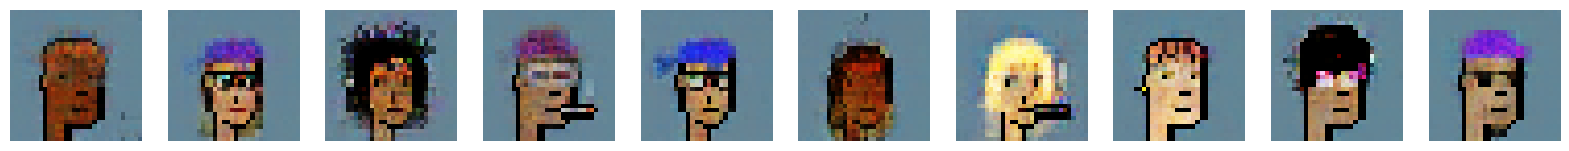

313/313 [==============================] - 49s 156ms/step - c_loss: -12.6934 - c_wass_loss: -16.7314 - c_gp: 0.4038 - g_loss: 23.0199
Epoch 21/50
217/313 [===================>..........] - ETA: 14s - c_loss: -12.2729 - c_wass_loss: -16.2735 - c_gp: 0.4001 - g_loss: 23.0585

KeyboardInterrupt: 

In [71]:
wgangp.fit(
    train,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator_wgan(num_img=10, latent_dim=100),
    ],
)

WGAN-GP training was stopped earlier

#### Generating with WGAN-GP

1/1 [==============================] - 0s 31ms/step


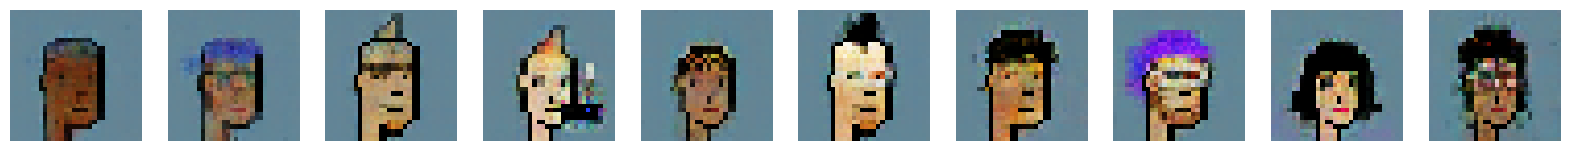

In [72]:
z_sample = np.random.normal(size=(10, 100))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

## Generation Comparision

### DCGAN

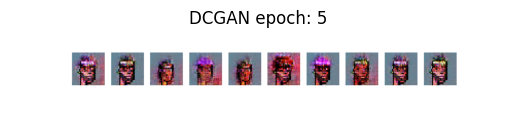

In [81]:
plt.imshow(plt.imread("/content/output/generated_img_004.png"))
plt.title("DCGAN epoch: 5")
plt.axis(False);


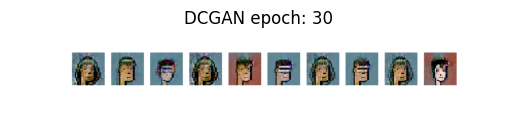

In [82]:
plt.imshow(plt.imread("/content/output/generated_img_029.png"))
plt.title("DCGAN epoch: 30")
plt.axis(False);

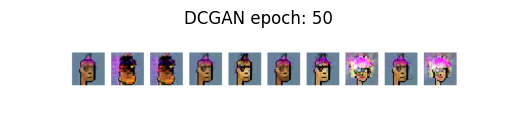

In [83]:
plt.imshow(plt.imread("/content/output/generated_img_049.png"))
plt.title("DCGAN epoch: 50")
plt.axis(False);

### WGAN-GP

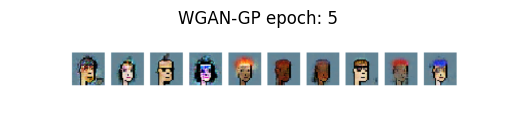

In [85]:
plt.imshow(plt.imread("/content/output_wgan/generated_img_004.png"))
plt.title("WGAN-GP epoch: 5")
plt.axis(False);

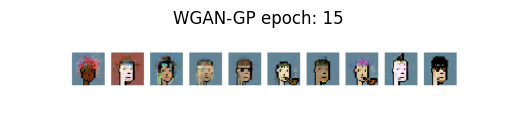

In [86]:
plt.imshow(plt.imread("/content/output_wgan/generated_img_014.png"))
plt.title("WGAN-GP epoch: 15")
plt.axis(False);

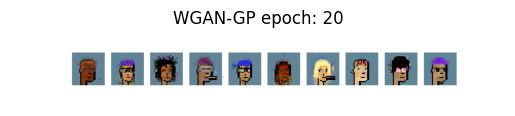

In [87]:
plt.imshow(plt.imread("/content/output_wgan/generated_img_019.png"))
plt.title("WGAN-GP epoch: 20")
plt.axis(False);

Here it can clearly be seen that wgan-gp generates far better images in way lesser number of epochs